In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEVICE)
print(torch.__version__)
print(torch.version.cuda)
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

cuda:0
1.11.0
11.3


In [2]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))


In [3]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


In [4]:
import torch
from nuwa_pytorch import VQGanVAE
from nuwa_pytorch.optimizer import get_optimizer
vae = VQGanVAE(
    dim = 256,
    channels = 1,               
    image_size = 256,           # image size
    num_layers = 4,             # number of downsampling layers
    num_resnet_blocks = 2,      # number of resnet blocks
    vq_codebook_size = 1024,    # codebook size
    vq_decay = 0.3 ,             # codebook exponential decay
    use_hinge_loss = True,
    use_vgg_and_gan = True
).to(DEVICE)

all_parameters = set(vae.parameters())
discr_parameters = set(vae.discr.parameters())
vae_parameters = all_parameters - discr_parameters

lr = 1e-4
wd = 0.001
optim = get_optimizer(vae_parameters, lr = lr, wd = wd)
discr_optim = get_optimizer(discr_parameters, lr = lr, wd = wd)

In [5]:
checkpoint = torch.load('/space/junzheyin/vae_epoch80', map_location = DEVICE)
vae.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [14]:
print(vae)

VQGanVAE(
  (encoders): ModuleList(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (4): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (5): ResBlock(
      (net): Sequential(
        (0): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 2048, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
from torchsummary import summary
input=(1,256,256)

summary(vae,input)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 256, 256]           6,656
            Conv2d-2        [-1, 256, 128, 128]       1,048,832
         LeakyReLU-3        [-1, 256, 128, 128]               0
            Conv2d-4          [-1, 512, 64, 64]       2,097,664
         LeakyReLU-5          [-1, 512, 64, 64]               0
            Conv2d-6         [-1, 1024, 32, 32]       8,389,632
         LeakyReLU-7         [-1, 1024, 32, 32]               0
            Conv2d-8         [-1, 2048, 16, 16]      33,556,480
         LeakyReLU-9         [-1, 2048, 16, 16]               0
           Conv2d-10         [-1, 2048, 16, 16]      37,750,784
        GroupNorm-11         [-1, 2048, 16, 16]           4,096
        LeakyReLU-12         [-1, 2048, 16, 16]               0
           Conv2d-13         [-1, 2048, 16, 16]      37,750,784
        GroupNorm-14         [-1, 2048,

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

: 

In [6]:
codebook = vae.vq.project_out

weight_size = codebook.weight.size()
bias_size = codebook.bias.size()

print("Weight size:", weight_size)
print("Bias size:", bias_size)

Weight size: torch.Size([2048, 256])
Bias size: torch.Size([2048])


ss4 torch.Size([1, 9, 256, 256])
ss3 torch.Size([1, 9, 1, 256, 256])
Codebook torch.Size([1, 2304, 256])
codes torch.Size([1, 2304, 2048])
torch.Size([9, 2048, 16, 16])
video1 torch.Size([9, 1, 256, 256])
video2 torch.Size([1, 9, 1, 256, 256])
video3 torch.Size([1, 9, 256, 256])
ss4 torch.Size([1, 9, 256, 256])
ss3 torch.Size([1, 9, 1, 256, 256])
Codebook torch.Size([1, 2304, 256])
codes torch.Size([1, 2304, 2048])
torch.Size([9, 2048, 16, 16])
video1 torch.Size([9, 1, 256, 256])
video2 torch.Size([1, 9, 1, 256, 256])
video3 torch.Size([1, 9, 256, 256])
ss4 torch.Size([1, 9, 256, 256])
ss3 torch.Size([1, 9, 1, 256, 256])
Codebook torch.Size([1, 2304, 256])
codes torch.Size([1, 2304, 2048])
torch.Size([9, 2048, 16, 16])
video1 torch.Size([9, 1, 256, 256])
video2 torch.Size([1, 9, 1, 256, 256])
video3 torch.Size([1, 9, 256, 256])
ss4 torch.Size([1, 9, 256, 256])
ss3 torch.Size([1, 9, 1, 256, 256])
Codebook torch.Size([1, 2304, 256])
codes torch.Size([1, 2304, 2048])
torch.Size([9, 2048, 

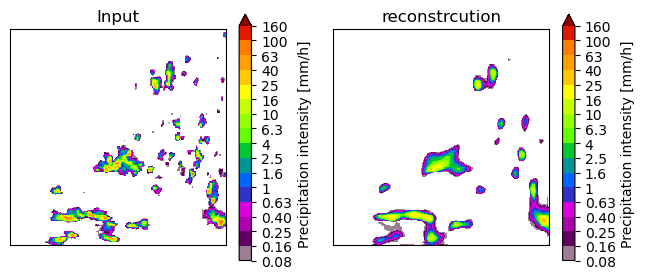

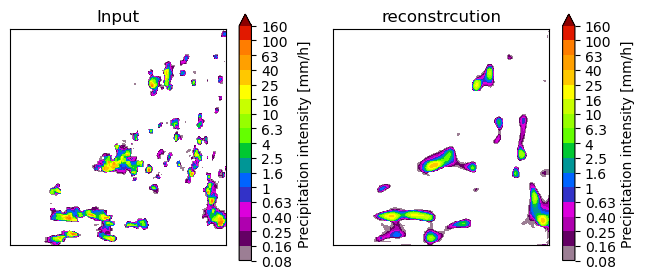

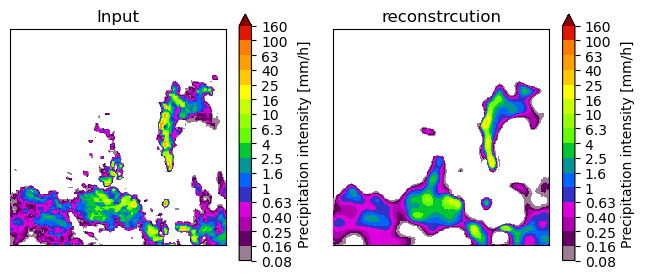

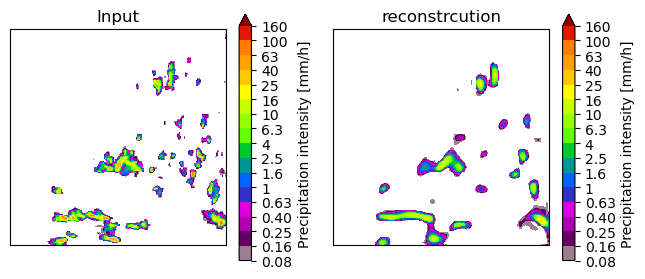

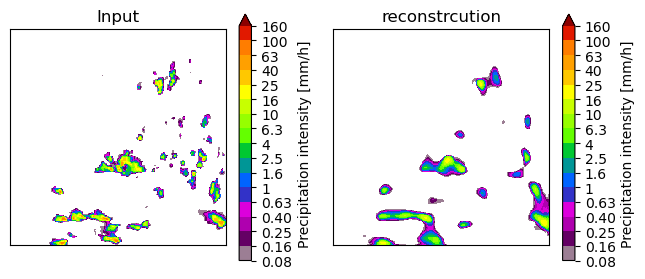

In [10]:
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from einops import rearrange, reduce, repeat
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break
    print("ss4",images.size())
    a = Variable(images).to(DEVICE).unsqueeze(2).to(DEVICE)
    print("ss3",a.size())
    vae.to(DEVICE)
    indices = vae.get_video_indices(a)
    indices = torch.flatten(indices).unsqueeze(0)
    
    codes = vae.vq.codebook[indices]
    print("Codebook",codes.size())
    
    indices = codes.float()
    codes=vae.vq.project_out(indices)
    print("codes",codes.size())
    b = indices.shape[0]
    codes = rearrange(codes, 'b (f h w) d -> (b f) d h w', h = vae.fmap_size, w = vae.fmap_size)
    print(codes.size())
    video = vae.decode(codes)
    print("video1",video.size())
    video = rearrange(video, '(b f) ... -> b f ...', b = b)
    print("video2",video.size())
    video3 = Variable(video).squeeze(2)
    print("video3",video3.size())

    for t in range(1):
         a_display = images[t,0,:,:].to('cpu').detach().numpy()*40
         a_r_display = video3[t,0,:,:].to('cpu').detach().numpy()*40
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plot_precip_field(a_display, title="Input")
    plt.subplot(142)
    plot_precip_field(a_r_display, title="reconstrcution")


In [14]:
print(vae)

VQGanVAE(
  (encoders): ModuleList(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (4): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (5): ResBlock(
      (net): Sequential(
        (0): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 2048, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padd

torch.Size([1, 1, 256, 256])
MSE: 10.611 MAE: 0.687 PCC: 0.633 
 MSE: 9.359 MAE: 0.647 PCC: 0.679 
 MSE: 7.362 MAE: 0.588 PCC: 0.76 
 CSI(1mm): 0.574 CSI(2mm): 0.473 CSI(8mm): 0.238 
 ACC(1mm): 0.937 ACC(2mm): 0.949 ACC(8mm): 0.975 
 FSS(1km): 0.974 FSS(10km): 0.961 FSS(20km): 0.928 FSS(30km): 0.818 
 CSI(1mm): 0.57 CSI(2mm): 0.527 CSI(8mm): 0.425 
 ACC(1mm): 0.94 ACC(2mm): 0.957 ACC(8mm): 0.978 
 FSS(1km): 0.96 FSS(10km): 0.946 FSS(20km): 0.91 FSS(30km): 0.796 



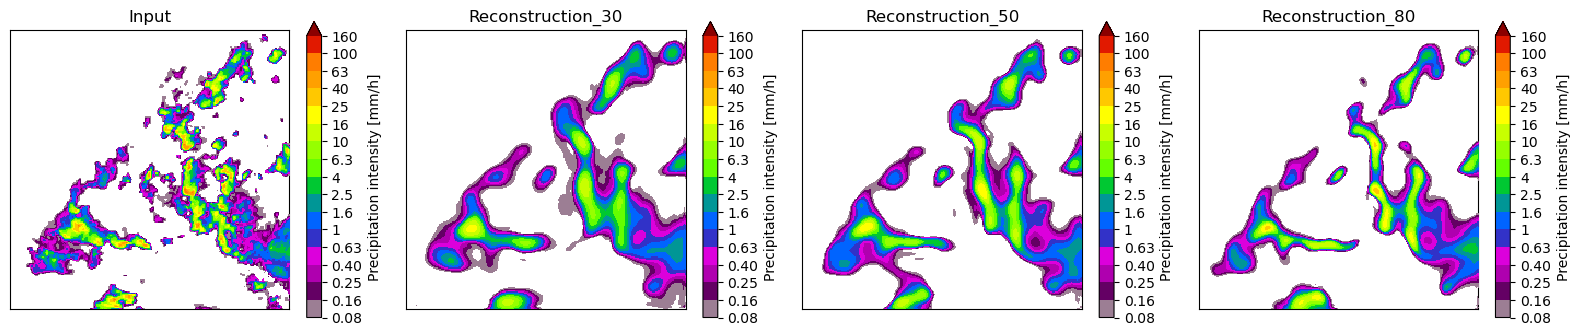

torch.Size([1, 1, 256, 256])
MSE: 11.984 MAE: 0.678 PCC: 0.599 
 MSE: 10.15 MAE: 0.647 PCC: 0.663 
 MSE: 8.89 MAE: 0.602 PCC: 0.7 
 CSI(1mm): 0.586 CSI(2mm): 0.472 CSI(8mm): 0.228 
 ACC(1mm): 0.939 ACC(2mm): 0.95 ACC(8mm): 0.974 
 FSS(1km): 0.973 FSS(10km): 0.961 FSS(20km): 0.928 FSS(30km): 0.817 
 CSI(1mm): 0.601 CSI(2mm): 0.545 CSI(8mm): 0.417 
 ACC(1mm): 0.944 ACC(2mm): 0.956 ACC(8mm): 0.977 
 FSS(1km): 0.961 FSS(10km): 0.948 FSS(20km): 0.91 FSS(30km): 0.796 



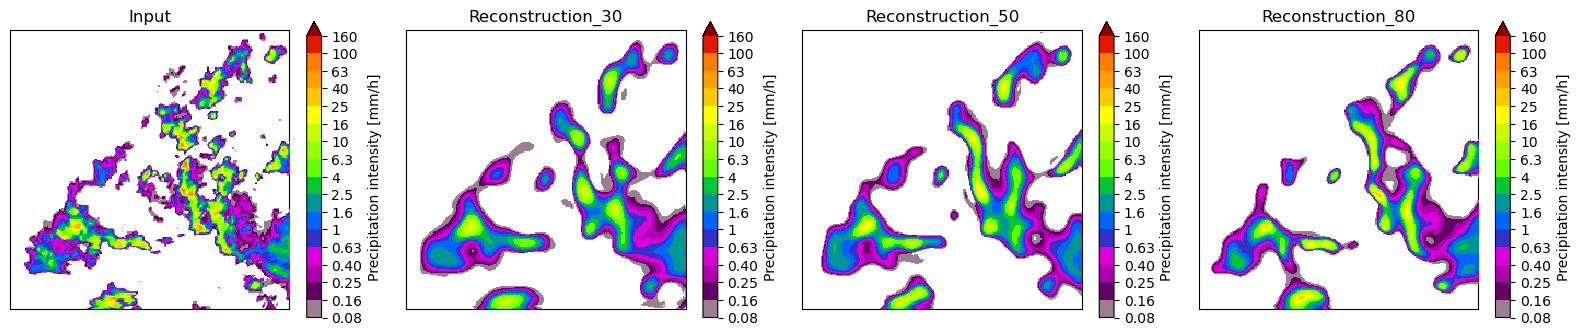

torch.Size([1, 1, 256, 256])
MSE: 1.089 MAE: 0.293 PCC: 0.756 
 MSE: 0.891 MAE: 0.269 PCC: 0.814 
 MSE: 0.823 MAE: 0.255 PCC: 0.826 
 CSI(1mm): 0.705 CSI(2mm): 0.593 CSI(8mm): 0.167 
 ACC(1mm): 0.945 ACC(2mm): 0.956 ACC(8mm): 0.993 
 FSS(1km): 0.991 FSS(10km): 0.985 FSS(20km): 0.968 FSS(30km): 0.907 
 CSI(1mm): 0.724 CSI(2mm): 0.608 CSI(8mm): 0.244 
 ACC(1mm): 0.951 ACC(2mm): 0.959 ACC(8mm): 0.994 
 FSS(1km): 0.993 FSS(10km): 0.988 FSS(20km): 0.973 FSS(30km): 0.91 



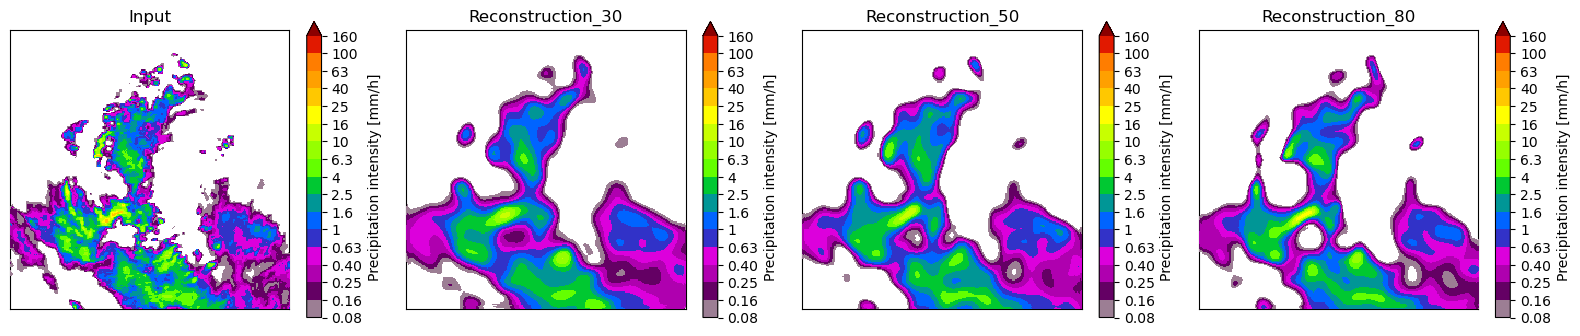

torch.Size([1, 1, 256, 256])
MSE: 13.024 MAE: 0.715 PCC: 0.632 
 MSE: 10.958 MAE: 0.673 PCC: 0.685 
 MSE: 9.774 MAE: 0.643 PCC: 0.727 
 CSI(1mm): 0.549 CSI(2mm): 0.444 CSI(8mm): 0.279 
 ACC(1mm): 0.934 ACC(2mm): 0.947 ACC(8mm): 0.976 
 FSS(1km): 0.98 FSS(10km): 0.967 FSS(20km): 0.931 FSS(30km): 0.809 
 CSI(1mm): 0.566 CSI(2mm): 0.475 CSI(8mm): 0.376 
 ACC(1mm): 0.94 ACC(2mm): 0.953 ACC(8mm): 0.978 
 FSS(1km): 0.964 FSS(10km): 0.95 FSS(20km): 0.911 FSS(30km): 0.794 



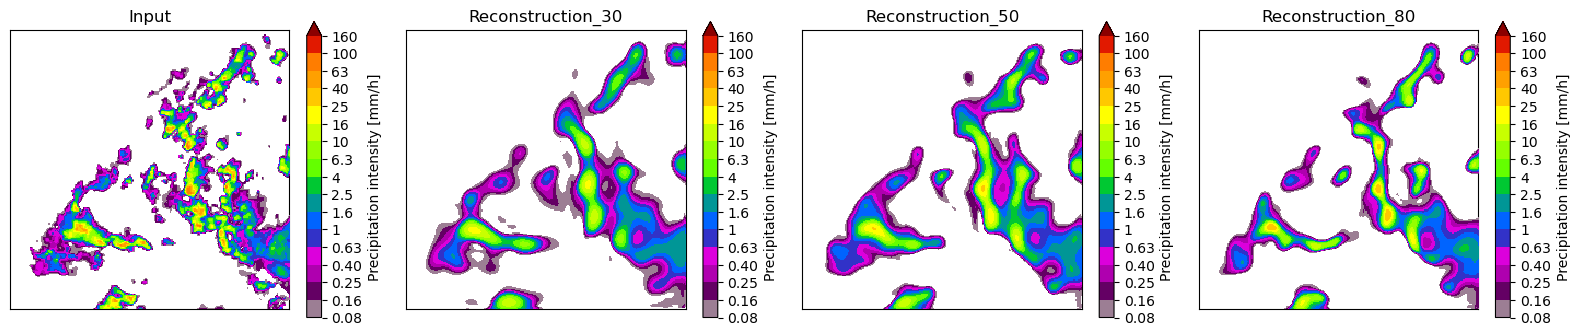

torch.Size([1, 1, 256, 256])
MSE: 14.855 MAE: 0.774 PCC: 0.6 
 MSE: 13.771 MAE: 0.725 PCC: 0.64 
 MSE: 11.803 MAE: 0.701 PCC: 0.702 
 CSI(1mm): 0.512 CSI(2mm): 0.416 CSI(8mm): 0.257 
 ACC(1mm): 0.93 ACC(2mm): 0.944 ACC(8mm): 0.974 
 FSS(1km): 0.981 FSS(10km): 0.967 FSS(20km): 0.927 FSS(30km): 0.802 
 CSI(1mm): 0.581 CSI(2mm): 0.52 CSI(8mm): 0.341 
 ACC(1mm): 0.94 ACC(2mm): 0.953 ACC(8mm): 0.974 
 FSS(1km): 0.958 FSS(10km): 0.943 FSS(20km): 0.906 FSS(30km): 0.791 



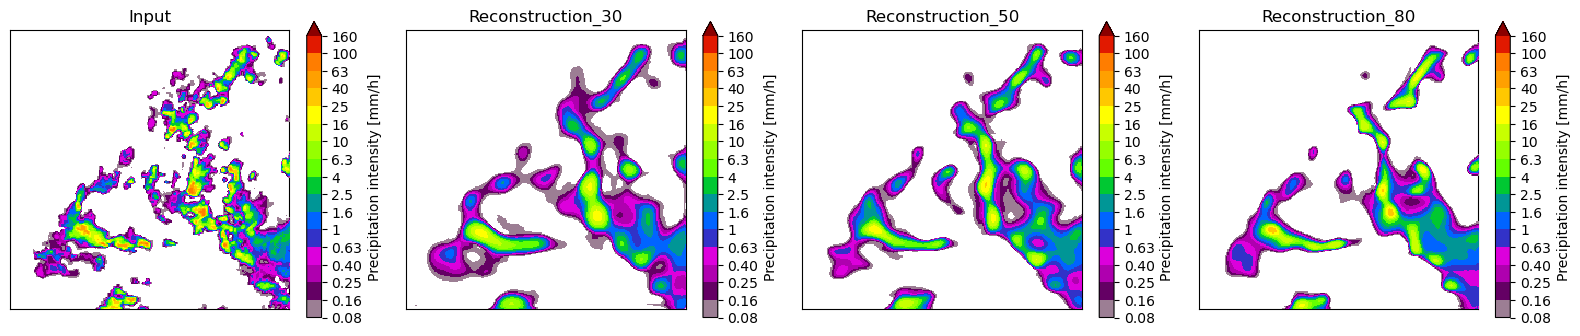

pcc_average: 0.644
pcc_average1: 0.6962
pcc_average2: 0.743


: 

In [11]:
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cpu'
pcc_average = 0
pcc_average1 = 0
pcc_average2 = 0
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break
    for image in images:
        image = image.unsqueeze(1)
        a = Variable(image).to(device)   # batch x
        vae = vae.to(device)
        #model1024 = model1024.to(device)
        a = a[4:5, :, :, :]
        print(a.size())
        checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch30', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r = vae(a)
        checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch50', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r1 = vae(a)
        checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch80', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r2 = vae(a)

        for t in range(1):
            #a_display = (a[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
            #a_r_display = (a_r[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
            a_display = a[t,0,:,:].to('cpu').detach().numpy()*40
            a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
            a_r1_display = a_r1[t,0,:,:].to('cpu').detach().numpy()*40
            a_r2_display = a_r2[t,0,:,:].to('cpu').detach().numpy()*40
            
            #np.save('reconstruct_sample{}_gt'.format(i+1), a_display)
            #np.save('reconstruct_sample{}_vqgan1'.format(i+1), a_r_display)
            #np.save('reconstruct_sample{}_vqgan2'.format(i+1), a_r2_display)
            
            scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
            scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
            scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
            scores_cat12 = det_cat_fct(a_r2_display, a_display, 1)
            scores_cat22 = det_cat_fct(a_r2_display, a_display, 2)
            scores_cat82 = det_cat_fct(a_r2_display, a_display, 8)
            scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
            scores_cont2 = det_cont_fct(a_r1_display, a_display, thr=0.1)
            scores_cont3 = det_cont_fct(a_r2_display, a_display, thr=0.1)
            scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
            scores_spatial2 = intensity_scale(a_r2_display, a_display, 'FSS', 0.1, [1,10,20,30])
            pcc_average += float(np.around(scores_cont['corr_p'],3))
            pcc_average1 += float(np.around(scores_cont2['corr_p'],3))
            pcc_average2 += float(np.around(scores_cont3['corr_p'],3))
            if True:
                print('MSE:', np.around(scores_cont['MSE'],3), 
                      'MAE:', np.around(scores_cont['MAE'],3), 
                      'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                      'MSE:', np.around(scores_cont2['MSE'],3), 
                      'MAE:', np.around(scores_cont2['MAE'],3), 
                      'PCC:', np.around(scores_cont2['corr_p'],3),'\n',
                      'MSE:', np.around(scores_cont3['MSE'],3), 
                      'MAE:', np.around(scores_cont3['MAE'],3), 
                      'PCC:', np.around(scores_cont3['corr_p'],3),'\n',
                      'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                      'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                      'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                      'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                      'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                      'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                      'FSS(1km):', np.around(scores_spatial[0][0],3),
                      'FSS(10km):', np.around(scores_spatial[1][0],3),
                      'FSS(20km):', np.around(scores_spatial[2][0],3),
                      'FSS(30km):', np.around(scores_spatial[3][0],3),'\n',
                      'CSI(1mm):', np.around(scores_cat12['CSI'],3), # CSI: TP/(TP+FP+FN)
                      'CSI(2mm):', np.around(scores_cat22['CSI'],3),
                      'CSI(8mm):', np.around(scores_cat82['CSI'],3),'\n',
                      'ACC(1mm):', np.around(scores_cat12['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                      'ACC(2mm):', np.around(scores_cat22['ACC'],3),
                      'ACC(8mm):', np.around(scores_cat82['ACC'],3),'\n',
                      'FSS(1km):', np.around(scores_spatial2[0][0],3),
                      'FSS(10km):', np.around(scores_spatial2[1][0],3),
                      'FSS(20km):', np.around(scores_spatial2[2][0],3),
                      'FSS(30km):', np.around(scores_spatial2[3][0],3),'\n',
                     )  
                plt.figure(figsize=(16,4))
                plt.subplot(141)
                plot_precip_field(a_display, title="Input")
                plt.subplot(142)
                plot_precip_field(a_r_display, title="Reconstruction_30")
                plt.subplot(143)
                plot_precip_field(a_r1_display, title="Reconstruction_50")
                plt.subplot(144)
                plot_precip_field(a_r2_display, title="Reconstruction_80")
                plt.tight_layout()
                plt.show()
print('pcc_average:', pcc_average/i)
print('pcc_average1:', pcc_average1/i)
print('pcc_average2:', pcc_average2/i)

In [6]:
# Continue training the VQ-GAN
import time
from torch import nn
from tqdm import tqdm
from math import log
num_epochs = 80
count = 0
loss_sum = 0
loss_sum_dis = 0
loss_sum_total = 0
total_step = len(loaders['train'])
discr_loss = 0
loss_ae = 0
for g in optim.param_groups:
    g['lr'] = 3e-6
for g in discr_optim.param_groups:
    g['lr'] = 3e-6
for epoch in range(num_epochs):
    print('')
    #print("epoch {}".format(epoch))
    loss_sum = 0
    loss_sum_dis = 0
    count = 0
    count_dis = 0
    logit_true_sum = 0
    logit_fake_sum = 0
    #bar = tqdm(loaders['train_aa5'])
    for i, images in enumerate(loaders['train']):
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        a = Variable(image).to(DEVICE)   # batch x
        vae = vae.to(DEVICE)
        
        loss_ae = vae(a,return_loss = True)
        discr_loss = vae(a, return_discr_loss = True)
        #logit_fake_sum += float(fmap_discr_logits.mean())
        #logit_true_sum += float(img_discr_logits.mean())
        #print(fmap_discr_logits.mean(), img_discr_logits.mean())
        loss_sum += float(loss_ae)
        loss_sum_dis += float(discr_loss)
        
    
        if 0 < (i+1) % 128 < 65:
            (discr_loss / 64).backward()
            count_dis += 1 
            if count_dis % 64 == 0:
                discr_optim.step()
                discr_optim.zero_grad()
        else: 
            (loss_ae / 64).backward() 
            count += 1 
            if count % 64 == 0:
                optim.step()
                optim.zero_grad()
          
        #bar.set_postfix_str('ae loss:{:.4f},dis loss:{:.4f}'.format(float(loss_ae)\(i+1), loss_dis))
        print('Epoch {}, {}/ {},ae loss:{:.4f},dis loss:{:.4f}'
              .format(epoch+1, i+1, total_step, loss_sum/(i+1), loss_sum_dis/(i+1), ), end='\r')


Epoch 1, 30632/ 30632,ae loss:0.0288,dis loss:0.7910
Epoch 2, 30632/ 30632,ae loss:0.0086,dis loss:0.6853


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 3, 30632/ 30632,ae loss:0.0079,dis loss:0.3118
Epoch 4, 30632/ 30632,ae loss:0.0073,dis loss:0.1954
Epoch 5, 30632/ 30632,ae loss:0.0068,dis loss:0.1584
Epoch 6, 30632/ 30632,ae loss:0.0069,dis loss:0.1213


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 8, 30632/ 30632,ae loss:0.0062,dis loss:0.0749
Epoch 9, 30632/ 30632,ae loss:0.0062,dis loss:0.0460
Epoch 10, 30632/ 30632,ae loss:0.0059,dis loss:0.0394
Epoch 11, 30632/ 30632,ae loss:0.0059,dis loss:0.0311
Epoch 12, 30632/ 30632,ae loss:0.0057,dis loss:0.0160
Epoch 13, 30632/ 30632,ae loss:0.0056,dis loss:0.0390
Epoch 14, 30632/ 30632,ae loss:0.0064,dis loss:0.0648
Epoch 15, 30632/ 30632,ae loss:0.0057,dis loss:0.0171
Epoch 16, 30632/ 30632,ae loss:0.0055,dis loss:0.0146
Epoch 17, 30632/ 30632,ae loss:0.0055,dis loss:0.0165
Epoch 18, 30632/ 30632,ae loss:0.0054,dis loss:0.0198
Epoch 19, 30632/ 30632,ae loss:0.0053,dis loss:0.0227
Epoch 20, 30632/ 30632,ae loss:0.0054,dis loss:0.0208
Epoch 21, 30632/ 30632,ae loss:0.0053,dis loss:0.0180
Epoch 22, 30632/ 30632,ae loss:0.0054,dis loss:0.0388
Epoch 23, 30632/ 30632,ae loss:0.0052,dis loss:0.0152
Epoch 24, 30632/ 30632,ae loss:0.0052,dis loss:0.0110
Epoch 25, 30632/ 30632,ae loss:0.0052,dis loss:0.0133
Epoch 26, 30632/ 30632,ae loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 47, 30632/ 30632,ae loss:0.0047,dis loss:0.0476
Epoch 48, 30632/ 30632,ae loss:0.0047,dis loss:0.0073
Epoch 49, 30632/ 30632,ae loss:0.0047,dis loss:0.0066
Epoch 50, 30632/ 30632,ae loss:0.0046,dis loss:0.0071
Epoch 51, 30632/ 30632,ae loss:0.0046,dis loss:0.0064
Epoch 52, 30632/ 30632,ae loss:0.0046,dis loss:0.0080
Epoch 53, 30632/ 30632,ae loss:0.0046,dis loss:0.0210
Epoch 54, 30632/ 30632,ae loss:0.0046,dis loss:0.0072
Epoch 55, 30632/ 30632,ae loss:0.0046,dis loss:0.0053
Epoch 56, 30632/ 30632,ae loss:0.0045,dis loss:0.0089
Epoch 57, 30632/ 30632,ae loss:0.0045,dis loss:0.0073
Epoch 58, 30632/ 30632,ae loss:0.0045,dis loss:0.0058
Epoch 59, 30632/ 30632,ae loss:0.0046,dis loss:0.0115
Epoch 60, 30632/ 30632,ae loss:0.0045,dis loss:0.0061


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 64, 30632/ 30632,ae loss:0.0045,dis loss:0.0094
Epoch 65, 30632/ 30632,ae loss:0.0045,dis loss:0.0191
Epoch 66, 30632/ 30632,ae loss:0.0045,dis loss:0.0056
Epoch 67, 30632/ 30632,ae loss:0.0044,dis loss:0.0064
Epoch 68, 30632/ 30632,ae loss:0.0045,dis loss:0.0053
Epoch 69, 30632/ 30632,ae loss:0.0044,dis loss:0.0053
Epoch 70, 30632/ 30632,ae loss:0.0044,dis loss:0.0054
Epoch 71, 30632/ 30632,ae loss:0.0044,dis loss:0.0104
Epoch 72, 30632/ 30632,ae loss:0.0044,dis loss:0.0086
Epoch 73, 30632/ 30632,ae loss:0.0044,dis loss:0.0058
Epoch 74, 30632/ 30632,ae loss:0.0043,dis loss:0.0059
Epoch 75, 30632/ 30632,ae loss:0.0043,dis loss:0.0060
Epoch 76, 30632/ 30632,ae loss:0.0043,dis loss:0.0067
Epoch 77, 30632/ 30632,ae loss:0.0043,dis loss:0.0094
Epoch 78, 30632/ 30632,ae loss:0.0043,dis loss:0.0062
Epoch 79, 30632/ 30632,ae loss:0.0043,dis loss:0.0050


In [5]:
torch.save(vae.state_dict(), '/bulk/junzheyin/vae_epoch80')

KeyboardInterrupt: 

In [36]:
# Get distribution of the latent space tokens
vae.to(DEVICE)
from collections import Counter
from tqdm import tqdm
counter = Counter()
for i, images in enumerate(tqdm(loaders['test'])):
    images = images.unsqueeze(1)
    a = Variable(images).to(DEVICE)   # batch x

    a = a[:,:, 0:1, :, :]
    indice = vae.get_video_indices(a)
    #print(indice.shape)
    counter.update(torch.flatten(indice).to('cpu').detach().numpy())
            
print(counter)
print(len(counter))

100%|██████████| 3493/3493 [00:56<00:00, 62.00it/s]

Counter({376: 339322, 3: 166784, 206: 37428, 218: 29283, 299: 27323, 922: 26781, 743: 22096, 174: 21446, 511: 20550, 89: 20416, 312: 20218, 921: 17039, 749: 16991, 770: 14303, 856: 14247, 734: 12710, 483: 11450, 819: 11297, 437: 9645, 137: 8455, 960: 7657, 928: 7550, 900: 6956, 503: 5846, 895: 5409, 627: 5234, 954: 3683, 287: 1553, 265: 1483, 423: 1027, 600: 15, 860: 6, 191: 3, 429: 1, 55: 1})
35


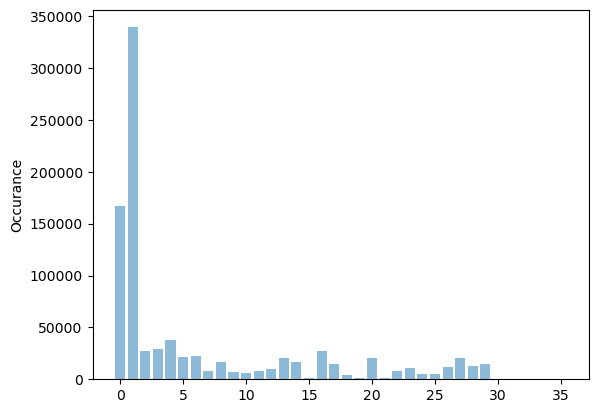

In [37]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

counter[66] = 0
objects = counter.keys()
y_pos = np.arange(len(objects))
occurance = counter.values()

plt.bar(y_pos, occurance, align='center', alpha=0.5)
plt.ylabel('Occurance')

plt.show()

In [7]:
# convert dataset to latent space
# transform all to latent space, store it

name = ['train_aa5','train_dw5', 'train_del5','train_re5']
for i, images in enumerate(loaders['valid']):
    #if i>=1: break
    #print(i)
    #images = images.squeeze(1)
    #print("ss4",images.size())
    a = Variable(images).to(DEVICE).unsqueeze(2).to(DEVICE)
    #print("ss3",a.size())
    #print(a.shape)
    vae.to(DEVICE)
    indice = vae.get_video_indices(a)
    #print("ss2",indice.size())
    indice_obs = indice[:,:3, :, :]
    #print("ss1",indice_obs.size())
    indice_obs = torch.flatten(indice_obs).unsqueeze(0)
    indice_pre = indice[:,3:, :, :]
    #print("ss",indice_pre.size())
    indice_pre = torch.flatten(indice_pre).unsqueeze(0)
    #print(indice_obs.shape, indice_pre.shape)
    torch.save([indice_obs,indice_pre], '/bulk/junzheyin/vali1517_newvae/validset'+str(i)+'.pt')
    print(i, '/{}'.format(len(loaders['valid'])), end='\r')

In [15]:
class latentDataset(Dataset):
    def __init__(self, root_dir, radarset):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.radarset = radarset
    def __len__(self):
        if self.radarset: return len(self.radarset)
        else: return 30000
    def __getitem__(self, idx):
        dir_file = self.root_dir + str(idx) + '.pt'
        if os.path.exists(dir_file):
            video_in_latent, video_out_latent = torch.load(dir_file, map_location='cpu')
            return video_in_latent, video_out_latent
        else:
            print("File not found")
            return None

latent_valid = latentDataset('/bulk/junzheyin/vali1517_newvae/validset', dataset_vali)
latent_test = latentDataset('/bulk/junzheyin/test1820/testset', dataset_test)
latent_train_de5  = latentDataset('/bulk/junzheyin/train0814_Delf_newvae/trainset', dataset_train_del)
latent_train_aa5  = latentDataset('/bulk/junzheyin/train0814_Aa_newvae/trainset', dataset_train_aa)
latent_train_dw5  = latentDataset('/bulk/junzheyin/train0814_Dwar_newvae/trainset', dataset_train_dw)
latent_train_re5 = latentDataset('/bulk/junzheyin/train0814_Regge_newvae/trainset', dataset_train_re)
latent_list = [latent_train_de5, latent_train_aa5, latent_train_dw5, latent_train_re5]
latent_train_aadedwre = torch.utils.data.ConcatDataset(latent_list)

loaders_latent = { 'test' :DataLoader(latent_test, batch_size=1, shuffle=True, num_workers=0),
                  'train_aadedwre' :DataLoader(latent_train_aadedwre, batch_size=1, shuffle=True, num_workers=0),
                  #'train_del5' :DataLoader(latent_train_de5, batch_size=1, shuffle=True, num_workers=0),
                  'train_aa5' :DataLoader(latent_train_aa5, batch_size=1, shuffle=True, num_workers=0)}
print(len(loaders_latent['train_aa5']))

7575


torch.Size([1, 768])
torch.Size([1, 1536])
Codebook torch.Size([1, 1536, 256])
codes torch.Size([1, 1536, 2048])
torch.Size([6, 2048, 16, 16])
video1 torch.Size([6, 1, 256, 256])
video2 torch.Size([1, 6, 1, 256, 256])
video3 torch.Size([1, 6, 256, 256])


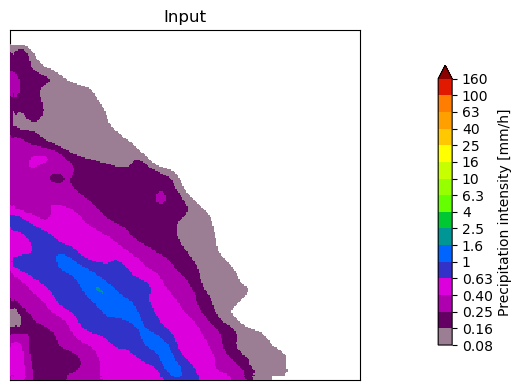

torch.Size([1, 768])
torch.Size([1, 1536])
Codebook torch.Size([1, 1536, 256])
codes torch.Size([1, 1536, 2048])
torch.Size([6, 2048, 16, 16])
video1 torch.Size([6, 1, 256, 256])
video2 torch.Size([1, 6, 1, 256, 256])
video3 torch.Size([1, 6, 256, 256])


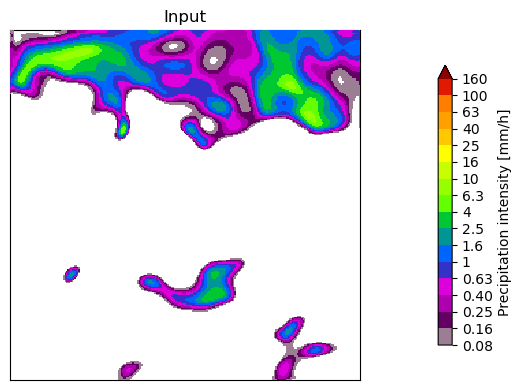

torch.Size([1, 768])
torch.Size([1, 1536])
Codebook torch.Size([1, 1536, 256])
codes torch.Size([1, 1536, 2048])
torch.Size([6, 2048, 16, 16])
video1 torch.Size([6, 1, 256, 256])
video2 torch.Size([1, 6, 1, 256, 256])
video3 torch.Size([1, 6, 256, 256])


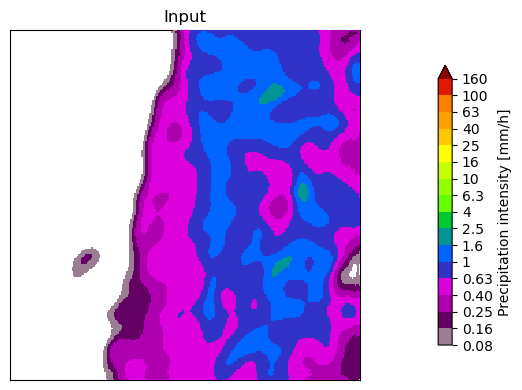

torch.Size([1, 768])
torch.Size([1, 1536])
Codebook torch.Size([1, 1536, 256])
codes torch.Size([1, 1536, 2048])
torch.Size([6, 2048, 16, 16])
video1 torch.Size([6, 1, 256, 256])
video2 torch.Size([1, 6, 1, 256, 256])
video3 torch.Size([1, 6, 256, 256])


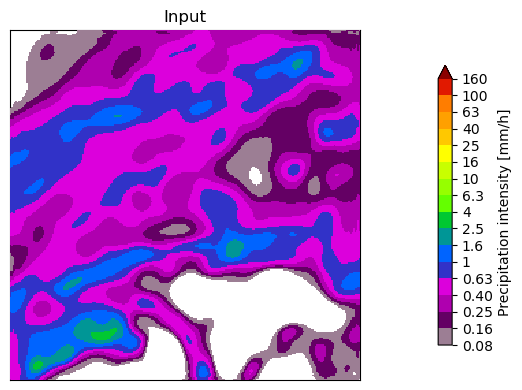

torch.Size([1, 768])
torch.Size([1, 1536])
Codebook torch.Size([1, 1536, 256])
codes torch.Size([1, 1536, 2048])
torch.Size([6, 2048, 16, 16])
video1 torch.Size([6, 1, 256, 256])
video2 torch.Size([1, 6, 1, 256, 256])
video3 torch.Size([1, 6, 256, 256])


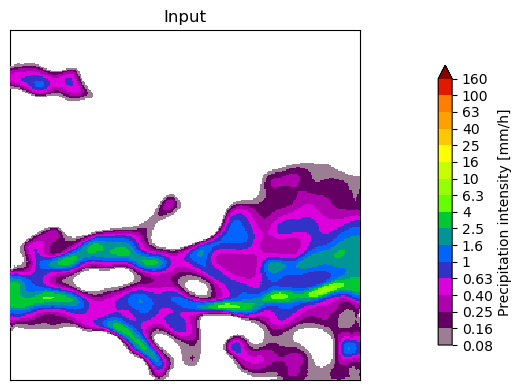

pcc_average: 0.0
pcc_average1: 0.0
pcc_average2: 0.0


: 

In [30]:
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from einops import rearrange, repeat
device = 'cpu'
pcc_average = 0
pcc_average1 = 0
pcc_average2 = 0
for i, latent in enumerate(loaders_latent['train_aadedwre']):
    if i<0:continue
    if i>=5:break
    latent_in = latent[0].to(DEVICE)
    latent_in=latent_in.squeeze(0)
    print(latent_in.size())
    latent_out = latent[1].to(DEVICE)
    latent_out=latent_out.squeeze(0)
    print(latent_out.size())
    codes = vae.vq.codebook[latent_out]
    print("Codebook",codes.size())
    
    codes = codes.float()
    codes=vae.vq.project_out(codes)
    print("codes",codes.size())
    
    b = codes.shape[0]
    codes = rearrange(codes, 'b (f h w) d -> (b f) d h w', h = vae.fmap_size, w = vae.fmap_size)
    print(codes.size())
    video = vae.decode(codes)
    print("video1",video.size())
    video = rearrange(video, '(b f) ... -> b f ...', b = b)
    print("video2",video.size())
    video_predict1 = Variable(video).squeeze(2)
    print("video3",video_predict1.size())
    for t in range(1):
        a_display = video_predict1[0,t,:,:].to('cpu').detach().numpy()*40
        plt.figure(figsize=(16,4))
        plot_precip_field(a_display, title="Input")
        plt.tight_layout()
        plt.show()
print('pcc_average:', pcc_average/i)
print('pcc_average1:', pcc_average1/i)
print('pcc_average2:', pcc_average2/i)